<a href="https://colab.research.google.com/github/dequiroz/1MTR53_RobIA/blob/main/graph_slam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/uc?export=view&id=1FsTa2YzWwxY-HBkd2EOXAlkPJ1zpikWv" alt="drawing" width="150"/>


<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1VBn7nKlruxCPLHH_UuD8B2pkvKP7JLRd" alt="drawing" width="800"/>

</br>

<img src="https://drive.google.com/uc?export=view&id=1uF_4x1YqLuS3M0mlh3NrMrEUHvjBMBFw" alt="drawing" width="800"/>
</p>

#Graph SLAM
* Diego Quiroz Velasquez
* Pontificia Universidad Católica del Perú
* Sección Ingeniería Mecatrónica

---
Este archivo describe ...

<img src="https://drive.google.com/uc?export=view&id=1vgFoFHEKMN0WcAFlKS2hPMg2KuBm3sp9" alt="drawing"/>



##Ejercicio 1

In [1]:
# -----------
# User Instructions
#
# Write a function, doit, that takes as its input an
# initial robot position, move1, and move2. This
# function should compute the Omega and Xi matrices
# discussed in lecture and should RETURN the mu vector
# (which is the product of Omega.inverse() and Xi).
#
# Please enter your code at the bottom.



from math import *
import random


#===============================================================
#
# SLAM in a rectolinear world (we avoid non-linearities)
#
#
#===============================================================


# ------------------------------------------------
#
# this is the matrix class
# we use it because it makes it easier to collect constraints in GraphSLAM
# and to calculate solutions (albeit inefficiently)
#

class matrix:

    # implements basic operations of a matrix class

    # ------------
    #
    # initialization - can be called with an initial matrix
    #

    def __init__(self, value = [[]]):
        self.value = value
        self.dimx  = len(value)
        self.dimy  = len(value[0])
        if value == [[]]:
            self.dimx = 0

    # ------------
    #
    # makes matrix of a certain size and sets each element to zero
    #

    def zero(self, dimx, dimy = 0):
        if dimy == 0:
            dimy = dimx
        # check if valid dimensions
        if dimx < 1 or dimy < 1:
            raise ValueError("Invalid size of matrix")
        else:
            self.dimx  = dimx
            self.dimy  = dimy
            self.value = [[0.0 for row in range(dimy)] for col in range(dimx)]

    # ------------
    #
    # makes matrix of a certain (square) size and turns matrix into identity matrix
    #


    def identity(self, dim):
        # check if valid dimension
        if dim < 1:
            raise ValueError("Invalid size of matrix")
        else:
            self.dimx  = dim
            self.dimy  = dim
            self.value = [[0.0 for row in range(dim)] for col in range(dim)]
            for i in range(dim):
                self.value[i][i] = 1.0
    # ------------
    #
    # prints out values of matrix
    #


    def show(self, txt = ''):
        for i in range(len(self.value)):
            print (txt + '['+ ', '.join('%.3f'%x for x in self.value[i]) + ']' )
        print (' ')

    # ------------
    #
    # defines elmement-wise matrix addition. Both matrices must be of equal dimensions
    #


    def __add__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimension to add")
        else:
            # add if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] + other.value[i][j]
            return res

    # ------------
    #
    # defines elmement-wise matrix subtraction. Both matrices must be of equal dimensions
    #

    def __sub__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimension to subtract")
        else:
            # subtract if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] - other.value[i][j]
            return res

    # ------------
    #
    # defines multiplication. Both matrices must be of fitting dimensions
    #


    def __mul__(self, other):
        # check if correct dimensions
        if self.dimy != other.dimx:
            raise ValueError("Matrices must be m*n and n*p to multiply")
        else:
            # multiply if correct dimensions
            res = matrix()
            res.zero(self.dimx, other.dimy)
            for i in range(self.dimx):
                for j in range(other.dimy):
                    for k in range(self.dimy):
                        res.value[i][j] += self.value[i][k] * other.value[k][j]
        return res


    # ------------
    #
    # returns a matrix transpose
    #


    def transpose(self):
        # compute transpose
        res = matrix()
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[ 1,  2,  3,  4,  5],
    #                   [ 6,  7,  8,  9, 10],
    #                   [11, 12, 13, 14, 15]])
    #
    #       l.take([0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 3, 4],
    #        [11, 13, 14]]
    #
    #
    # take is used to remove rows and columns from existing matrices
    # list1/list2 define a sequence of rows/columns that shall be taken
    # is no list2 is provided, then list2 is set to list1 (good for symmetric matrices)
    #

    def take(self, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError("list invalid in take()")

        res = matrix()
        res.zero(len(list1), len(list2))
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[i][j] = self.value[list1[i]][list2[j]]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[1, 2, 3],
    #                  [4, 5, 6]])
    #
    #       l.expand(3, 5, [0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 0, 2, 3, 0],
    #        [0, 0, 0, 0, 0],
    #        [4, 0, 5, 6, 0]]
    #
    # expand is used to introduce new rows and columns into an existing matrix
    # list1/list2 are the new indexes of row/columns in which the matrix
    # elements are being mapped. Elements for rows and columns
    # that are not listed in list1/list2
    # will be initialized by 0.0.
    #

    def expand(self, dimx, dimy, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError("list invalid in expand()")

        res = matrix()
        res.zero(dimx, dimy)
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[list1[i]][list2[j]] = self.value[i][j]
        return res

    # ------------
    #
    # Computes the upper triangular Cholesky factorization of
    # a positive definite matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def Cholesky(self, ztol= 1.0e-5):
        res = matrix()
        res.zero(self.dimx, self.dimx)

        for i in range(self.dimx):
            S = sum([(res.value[k][i])**2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else:
                if d < 0.0:
                    raise ValueError("Matrix not positive-definite")
                res.value[i][i] = sqrt(d)
            for j in range(i+1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(i)])
                if abs(S) < ztol:
                    S = 0.0
                try:
                   res.value[i][j] = (self.value[i][j] - S)/res.value[i][i]
                except:
                   raise ValueError("Zero diagonal")
        return res

    # ------------
    #
    # Computes inverse of matrix given its Cholesky upper Triangular
    # decomposition of matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def CholeskyInverse(self):
        res = matrix()
        res.zero(self.dimx, self.dimx)

    # Backward step for inverse.
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k]*res.value[j][k] for k in range(j+1, self.dimx)])
            res.value[j][j] = 1.0/ tjj**2 - S/ tjj
            for i in reversed(range(j)):
                res.value[j][i] = res.value[i][j] = \
                    -sum([self.value[i][k]*res.value[k][j] for k in \
                              range(i+1,self.dimx)])/self.value[i][i]
        return res

    # ------------
    #
    # comutes and returns the inverse of a square matrix
    #


    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res

    # ------------
    #
    # prints matrix (needs work!)
    #


    def __repr__(self):
        return repr(self.value)



# ######################################################################
# ######################################################################
# ######################################################################


"""
For the following example, you would call doit(-3, 5, 3):
3 robot positions
  initially: -3
  moves by 5
  moves by 3



which should return a mu of:
[[-3.0],
 [2.0],
 [5.0]]
"""
def doit(initial_pos, move1, move2):
    #
    #
    # Add your code here.
    Omega = matrix([[1.,0.,0.],[0.,0.,0.],[0.,0.,0.]])
    Xi = matrix([[initial_pos], [0.], [0.]])

    Omega += matrix([[1.,-1.,0.],[-1.,1.,0.],[0.,0.,0.]])
    Xi += matrix([[-move1], [move1], [0.]])

    Omega += matrix([[0.,0.,0.],[0.,1.,-1.],[0.,-1.,1.]])
    Xi += matrix([[0], [-move2], [move2]])

    Omega.show('Omega:    ')
    Xi.show('Xi:    ')
    mu = Omega.inverse() * Xi
    mu.show('Result:   ')

    #
    #
    return mu

doit(-3, 5, 3)



Omega:    [2.000, -1.000, 0.000]
Omega:    [-1.000, 2.000, -1.000]
Omega:    [0.000, -1.000, 1.000]
 
Xi:    [-8.000]
Xi:    [2.000]
Xi:    [3.000]
 
Result:   [-3.000]
Result:   [2.000]
Result:   [5.000]
 


[[-2.999999999999999], [2.0000000000000018], [5.000000000000002]]

##Ejercicio 2

In [2]:
# -----------
# User Instructions
#
# Write a function, doit, that takes as its input an
# initial robot position, move1, and move2. This
# function should compute the Omega and Xi matrices
# discussed in lecture and should RETURN the mu vector
# (which is the product of Omega.inverse() and Xi).
#
# Please enter your code at the bottom.



from math import *
import random


#===============================================================
#
# SLAM in a rectolinear world (we avoid non-linearities)
#
#
#===============================================================


# ------------------------------------------------
#
# this is the matrix class
# we use it because it makes it easier to collect constraints in GraphSLAM
# and to calculate solutions (albeit inefficiently)
#

class matrix:

    # implements basic operations of a matrix class

    # ------------
    #
    # initialization - can be called with an initial matrix
    #

    def __init__(self, value = [[]]):
        self.value = value
        self.dimx  = len(value)
        self.dimy  = len(value[0])
        if value == [[]]:
            self.dimx = 0

    # ------------
    #
    # makes matrix of a certain size and sets each element to zero
    #

    def zero(self, dimx, dimy = 0):
        if dimy == 0:
            dimy = dimx
        # check if valid dimensions
        if dimx < 1 or dimy < 1:
            raise ValueError("Invalid size of matrix")
        else:
            self.dimx  = dimx
            self.dimy  = dimy
            self.value = [[0.0 for row in range(dimy)] for col in range(dimx)]

    # ------------
    #
    # makes matrix of a certain (square) size and turns matrix into identity matrix
    #


    def identity(self, dim):
        # check if valid dimension
        if dim < 1:
            raise ValueError("Invalid size of matrix")
        else:
            self.dimx  = dim
            self.dimy  = dim
            self.value = [[0.0 for row in range(dim)] for col in range(dim)]
            for i in range(dim):
                self.value[i][i] = 1.0
    # ------------
    #
    # prints out values of matrix
    #


    def show(self, txt = ''):
        for i in range(len(self.value)):
            print (txt + '['+ ', '.join('%.3f'%x for x in self.value[i]) + ']' )
        print (' ')

    # ------------
    #
    # defines elmement-wise matrix addition. Both matrices must be of equal dimensions
    #


    def __add__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimension to add")
        else:
            # add if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] + other.value[i][j]
            return res

    # ------------
    #
    # defines elmement-wise matrix subtraction. Both matrices must be of equal dimensions
    #

    def __sub__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimension to subtract")
        else:
            # subtract if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] - other.value[i][j]
            return res

    # ------------
    #
    # defines multiplication. Both matrices must be of fitting dimensions
    #


    def __mul__(self, other):
        # check if correct dimensions
        if self.dimy != other.dimx:
            raise ValueError("Matrices must be m*n and n*p to multiply")
        else:
            # multiply if correct dimensions
            res = matrix()
            res.zero(self.dimx, other.dimy)
            for i in range(self.dimx):
                for j in range(other.dimy):
                    for k in range(self.dimy):
                        res.value[i][j] += self.value[i][k] * other.value[k][j]
        return res


    # ------------
    #
    # returns a matrix transpose
    #


    def transpose(self):
        # compute transpose
        res = matrix()
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[ 1,  2,  3,  4,  5],
    #                   [ 6,  7,  8,  9, 10],
    #                   [11, 12, 13, 14, 15]])
    #
    #       l.take([0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 3, 4],
    #        [11, 13, 14]]
    #
    #
    # take is used to remove rows and columns from existing matrices
    # list1/list2 define a sequence of rows/columns that shall be taken
    # is no list2 is provided, then list2 is set to list1 (good for symmetric matrices)
    #

    def take(self, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError("list invalid in take()")

        res = matrix()
        res.zero(len(list1), len(list2))
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[i][j] = self.value[list1[i]][list2[j]]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[1, 2, 3],
    #                  [4, 5, 6]])
    #
    #       l.expand(3, 5, [0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 0, 2, 3, 0],
    #        [0, 0, 0, 0, 0],
    #        [4, 0, 5, 6, 0]]
    #
    # expand is used to introduce new rows and columns into an existing matrix
    # list1/list2 are the new indexes of row/columns in which the matrix
    # elements are being mapped. Elements for rows and columns
    # that are not listed in list1/list2
    # will be initialized by 0.0.
    #

    def expand(self, dimx, dimy, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError("list invalid in expand()")

        res = matrix()
        res.zero(dimx, dimy)
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[list1[i]][list2[j]] = self.value[i][j]
        return res

    # ------------
    #
    # Computes the upper triangular Cholesky factorization of
    # a positive definite matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def Cholesky(self, ztol= 1.0e-5):
        res = matrix()
        res.zero(self.dimx, self.dimx)

        for i in range(self.dimx):
            S = sum([(res.value[k][i])**2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else:
                if d < 0.0:
                    raise ValueError("Matrix not positive-definite")
                res.value[i][i] = sqrt(d)
            for j in range(i+1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(i)])
                if abs(S) < ztol:
                    S = 0.0
                try:
                   res.value[i][j] = (self.value[i][j] - S)/res.value[i][i]
                except:
                   raise ValueError("Zero diagonal")
        return res

    # ------------
    #
    # Computes inverse of matrix given its Cholesky upper Triangular
    # decomposition of matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def CholeskyInverse(self):
        res = matrix()
        res.zero(self.dimx, self.dimx)

    # Backward step for inverse.
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k]*res.value[j][k] for k in range(j+1, self.dimx)])
            res.value[j][j] = 1.0/ tjj**2 - S/ tjj
            for i in reversed(range(j)):
                res.value[j][i] = res.value[i][j] = \
                    -sum([self.value[i][k]*res.value[k][j] for k in \
                              range(i+1,self.dimx)])/self.value[i][i]
        return res

    # ------------
    #
    # comutes and returns the inverse of a square matrix
    #


    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res

    # ------------
    #
    # prints matrix (needs work!)
    #


    def __repr__(self):
        return repr(self.value)



# ######################################################################
# ######################################################################
# ######################################################################


"""
For the following example, you would call doit(-3, 5, 3, 10, 5, 2):
3 robot positions
  initially: -3 (measure landmark to be 10 away)
  moves by 5 (measure landmark to be 5 away)
  moves by 3 (measure landmark to be 2 away)



which should return a mu of:
[[-3.0],
 [2.0],
 [5.0],
 [7.0]]
"""
def doit(initial_pos, move1, move2, Z0, Z1, Z2):
    Omega = matrix([[1.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0]])
    Xi = matrix([[initial_pos],
                 [0.0],
                 [0.0]])

    Omega += matrix([[1.0, -1.0, 0.0],
                     [-1.0, 1.0, 0.0],
                     [0.0, 0.0, 0.0]])
    Xi += matrix([[-move1],
                  [move1],
                  [0.0]])

    Omega += matrix([[0.0, 0.0, 0.0],
                     [0.0, 1.0, -1.0],
                     [0.0, -1.0, 1.0]])
    Xi += matrix([[0.0],
                  [-move2],
                  [move2]])

    #
    #
    # Add your code here.
    Omega = Omega.expand(4,4,[0,1,2],[0,1,2])
    Xi = Xi.expand(4,1,[0,1,2],[0])

    Omega += matrix([[1., 0., 0., -1.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [-1., 0., 0., 1.]])
    Xi += matrix([[-Z0],[0.],[0.], [Z0]])

    Omega += matrix([[0., 0., 0., 0.],
                     [0., 1., 0., -1.],
                     [0., 0., 0., 0.],
                     [0., -1., 0., 1.]])
    Xi += matrix([[0.],[-Z1],[0.], [Z1]])

    Omega += matrix([[0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 1., -1.],
                     [0., 0., -1., 1.]])
    Xi += matrix([[0.],[0.],[-Z2], [Z2]])

    #
    #

    Omega.show('Omega: ')
    Xi.show('Xi:    ')
    mu = Omega.inverse() * Xi
    mu.show('Mu:    ')

    return mu

doit(-5, 2, 6, 10, 8, 2)


Omega: [3.000, -1.000, 0.000, -1.000]
Omega: [-1.000, 3.000, -1.000, -1.000]
Omega: [0.000, -1.000, 2.000, -1.000]
Omega: [-1.000, -1.000, -1.000, 3.000]
 
Xi:    [-17.000]
Xi:    [-12.000]
Xi:    [4.000]
Xi:    [20.000]
 
Mu:    [-5.000]
Mu:    [-3.000]
Mu:    [3.000]
Mu:    [5.000]
 


[[-4.9999999999999964], [-3.0], [3.0000000000000036], [5.0000000000000036]]

##Ejercicio 3

In [3]:
# -----------
# User Instructions
#
# Write a function, doit, that takes as its input an
# initial robot position, move1, and move2. This
# function should compute the Omega and Xi matrices
# discussed in lecture and should RETURN the mu vector
# (which is the product of Omega.inverse() and Xi).
#
# Please enter your code at the bottom.



from math import *
import random


#===============================================================
#
# SLAM in a rectolinear world (we avoid non-linearities)
#
#
#===============================================================


# ------------------------------------------------
#
# this is the matrix class
# we use it because it makes it easier to collect constraints in GraphSLAM
# and to calculate solutions (albeit inefficiently)
#

class matrix:

    # implements basic operations of a matrix class

    # ------------
    #
    # initialization - can be called with an initial matrix
    #

    def __init__(self, value = [[]]):
        self.value = value
        self.dimx  = len(value)
        self.dimy  = len(value[0])
        if value == [[]]:
            self.dimx = 0

    # ------------
    #
    # makes matrix of a certain size and sets each element to zero
    #

    def zero(self, dimx, dimy = 0):
        if dimy == 0:
            dimy = dimx
        # check if valid dimensions
        if dimx < 1 or dimy < 1:
            raise ValueError("Invalid size of matrix")
        else:
            self.dimx  = dimx
            self.dimy  = dimy
            self.value = [[0.0 for row in range(dimy)] for col in range(dimx)]

    # ------------
    #
    # makes matrix of a certain (square) size and turns matrix into identity matrix
    #


    def identity(self, dim):
        # check if valid dimension
        if dim < 1:
            raise ValueError("Invalid size of matrix")
        else:
            self.dimx  = dim
            self.dimy  = dim
            self.value = [[0.0 for row in range(dim)] for col in range(dim)]
            for i in range(dim):
                self.value[i][i] = 1.0
    # ------------
    #
    # prints out values of matrix
    #


    def show(self, txt = ''):
        for i in range(len(self.value)):
            print (txt + '['+ ', '.join('%.3f'%x for x in self.value[i]) + ']' )
        print (' ')

    # ------------
    #
    # defines elmement-wise matrix addition. Both matrices must be of equal dimensions
    #


    def __add__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimension to add")
        else:
            # add if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] + other.value[i][j]
            return res

    # ------------
    #
    # defines elmement-wise matrix subtraction. Both matrices must be of equal dimensions
    #

    def __sub__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimension to subtract")
        else:
            # subtract if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] - other.value[i][j]
            return res

    # ------------
    #
    # defines multiplication. Both matrices must be of fitting dimensions
    #


    def __mul__(self, other):
        # check if correct dimensions
        if self.dimy != other.dimx:
            raise ValueError("Matrices must be m*n and n*p to multiply")
        else:
            # multiply if correct dimensions
            res = matrix()
            res.zero(self.dimx, other.dimy)
            for i in range(self.dimx):
                for j in range(other.dimy):
                    for k in range(self.dimy):
                        res.value[i][j] += self.value[i][k] * other.value[k][j]
        return res


    # ------------
    #
    # returns a matrix transpose
    #


    def transpose(self):
        # compute transpose
        res = matrix()
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[ 1,  2,  3,  4,  5],
    #                   [ 6,  7,  8,  9, 10],
    #                   [11, 12, 13, 14, 15]])
    #
    #       l.take([0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 3, 4],
    #        [11, 13, 14]]
    #
    #
    # take is used to remove rows and columns from existing matrices
    # list1/list2 define a sequence of rows/columns that shall be taken
    # is no list2 is provided, then list2 is set to list1 (good for symmetric matrices)
    #

    def take(self, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError("list invalid in take()")

        res = matrix()
        res.zero(len(list1), len(list2))
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[i][j] = self.value[list1[i]][list2[j]]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[1, 2, 3],
    #                  [4, 5, 6]])
    #
    #       l.expand(3, 5, [0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 0, 2, 3, 0],
    #        [0, 0, 0, 0, 0],
    #        [4, 0, 5, 6, 0]]
    #
    # expand is used to introduce new rows and columns into an existing matrix
    # list1/list2 are the new indexes of row/columns in which the matrix
    # elements are being mapped. Elements for rows and columns
    # that are not listed in list1/list2
    # will be initialized by 0.0.
    #

    def expand(self, dimx, dimy, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError("list invalid in expand()")

        res = matrix()
        res.zero(dimx, dimy)
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[list1[i]][list2[j]] = self.value[i][j]
        return res

    # ------------
    #
    # Computes the upper triangular Cholesky factorization of
    # a positive definite matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def Cholesky(self, ztol= 1.0e-5):
        res = matrix()
        res.zero(self.dimx, self.dimx)

        for i in range(self.dimx):
            S = sum([(res.value[k][i])**2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else:
                if d < 0.0:
                    raise ValueError("Matrix not positive-definite")
                res.value[i][i] = sqrt(d)
            for j in range(i+1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(i)])
                if abs(S) < ztol:
                    S = 0.0
                try:
                   res.value[i][j] = (self.value[i][j] - S)/res.value[i][i]
                except:
                   raise ValueError("Zero diagonal")
        return res

    # ------------
    #
    # Computes inverse of matrix given its Cholesky upper Triangular
    # decomposition of matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def CholeskyInverse(self):
        res = matrix()
        res.zero(self.dimx, self.dimx)

    # Backward step for inverse.
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k]*res.value[j][k] for k in range(j+1, self.dimx)])
            res.value[j][j] = 1.0/ tjj**2 - S/ tjj
            for i in reversed(range(j)):
                res.value[j][i] = res.value[i][j] = \
                    -sum([self.value[i][k]*res.value[k][j] for k in \
                              range(i+1,self.dimx)])/self.value[i][i]
        return res

    # ------------
    #
    # comutes and returns the inverse of a square matrix
    #


    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res

    # ------------
    #
    # prints matrix (needs work!)
    #


    def __repr__(self):
        return repr(self.value)



# ######################################################################
# ######################################################################
# ######################################################################


"""
For the following example, you would call doit(-3, 5, 3, 10, 5, 2):
3 robot positions
  initially: -3 (measure landmark to be 10 away)
  moves by 5 (measure landmark to be 5 away)
  moves by 3 (measure landmark to be 2 away)



which should return a mu of:
[[-3.0],
 [2.0],
 [5.0],
 [7.0]]
"""
def doit(initial_pos, move1, move2, Z0, Z1, Z2,Z3,Z4,Z5):
    Omega = matrix([[1.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0]])
    Xi = matrix([[initial_pos],
                 [0.0],
                 [0.0]])

    Omega += matrix([[1.0, -1.0, 0.0],
                     [-1.0, 1.0, 0.0],
                     [0.0, 0.0, 0.0]])
    Xi += matrix([[-move1],
                  [move1],
                  [0.0]])

    Omega += matrix([[0.0, 0.0, 0.0],
                     [0.0, 1.0, -1.0],
                     [0.0, -1.0, 1.0]])
    Xi += matrix([[0.0],
                  [-move2],
                  [move2]])

    #
    #
    # Add your code here.
    Omega = Omega.expand(4,4,[0,1,2],[0,1,2])
    Xi = Xi.expand(4,1,[0,1,2],[0])

    Omega += matrix([[1., 0., 0., -1.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [-1., 0., 0., 1.]])
    Xi += matrix([[-Z0],[0.],[0.], [Z0]])

    Omega += matrix([[0., 0., 0., 0.],
                     [0., 1., 0., -1.],
                     [0., 0., 0., 0.],
                     [0., -1., 0., 1.]])
    Xi += matrix([[0.],[-Z1],[0.], [Z1]])

    Omega += matrix([[0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 1., -1.],
                     [0., 0., -1., 1.]])
    Xi += matrix([[0.],[0.],[-Z2], [Z2]])

    #
    #
    Omega = Omega.expand(5,5,[0,1,2,3],[0,1,2,3])
    Xi = Xi.expand(5,1,[0,1,2,3],[0])
    Omega += matrix([[1., 0., 0., 0., -1.],
                     [0., 0., 0., 0., 0.],
                     [0., 0., 0., 0., 0.],
                     [0., 0., 0., 0., 0.],
                     [-1., 0., 0., 0., 1.]])
    Xi += matrix([[-Z3],[0.],[0.],[0.], [Z3]])

    Omega += matrix([[0., 0., 0., 0., 0.],
                     [0., 1., 0., 0., -1.],
                     [0., 0., 0., 0., 0.],
                     [0., 0., 0., 0., 0.],
                     [0., -1., 0., 0., 1.]])
    Xi += matrix([[0.],[-Z4],[0.],[0.], [Z4]])

    Omega += matrix([[0., 0., 0., 0., 0.],
                     [0., 0., 0., 0., 0.],
                     [0., 0., 1., 0., -1.],
                     [0., 0., 0., 0., 0.],
                     [0., 0., -1., 0., 1.]])
    Xi += matrix([[0.],[0.],[-Z5],[0.], [Z5]])

    Omega.show('Omega: ')
    Xi.show('Xi:    ')
    mu = Omega.inverse() * Xi
    mu.show('Mu:    ')

    return mu

doit(-5, 2, 6, 7, 5, -1,10,8,2)


Omega: [4.000, -1.000, 0.000, -1.000, -1.000]
Omega: [-1.000, 4.000, -1.000, -1.000, -1.000]
Omega: [0.000, -1.000, 3.000, -1.000, -1.000]
Omega: [-1.000, -1.000, -1.000, 3.000, 0.000]
Omega: [-1.000, -1.000, -1.000, 0.000, 3.000]
 
Xi:    [-24.000]
Xi:    [-17.000]
Xi:    [5.000]
Xi:    [11.000]
Xi:    [20.000]
 
Mu:    [-5.000]
Mu:    [-3.000]
Mu:    [3.000]
Mu:    [2.000]
Mu:    [5.000]
 


[[-5.000000000000007], [-3.0], [2.9999999999999893], [1.999999999999993], [4.9999999999999964]]

##Ejercicio 4

In [4]:
# -----------
# User Instructions
#
# Write a function, doit, that takes as its input an
# initial robot position, move1, and move2. This
# function should compute the Omega and Xi matrices
# discussed in lecture and should RETURN the mu vector
# (which is the product of Omega.inverse() and Xi).
#
# Please enter your code at the bottom.



from math import *
import random


#===============================================================
#
# SLAM in a rectolinear world (we avoid non-linearities)
#
#
#===============================================================


# ------------------------------------------------
#
# this is the matrix class
# we use it because it makes it easier to collect constraints in GraphSLAM
# and to calculate solutions (albeit inefficiently)
#

class matrix:

    # implements basic operations of a matrix class

    # ------------
    #
    # initialization - can be called with an initial matrix
    #

    def __init__(self, value = [[]]):
        self.value = value
        self.dimx  = len(value)
        self.dimy  = len(value[0])
        if value == [[]]:
            self.dimx = 0

    # ------------
    #
    # makes matrix of a certain size and sets each element to zero
    #

    def zero(self, dimx, dimy = 0):
        if dimy == 0:
            dimy = dimx
        # check if valid dimensions
        if dimx < 1 or dimy < 1:
            raise ValueError("Invalid size of matrix")
        else:
            self.dimx  = dimx
            self.dimy  = dimy
            self.value = [[0.0 for row in range(dimy)] for col in range(dimx)]

    # ------------
    #
    # makes matrix of a certain (square) size and turns matrix into identity matrix
    #


    def identity(self, dim):
        # check if valid dimension
        if dim < 1:
            raise ValueError("Invalid size of matrix")
        else:
            self.dimx  = dim
            self.dimy  = dim
            self.value = [[0.0 for row in range(dim)] for col in range(dim)]
            for i in range(dim):
                self.value[i][i] = 1.0
    # ------------
    #
    # prints out values of matrix
    #


    def show(self, txt = ''):
        for i in range(len(self.value)):
            print (txt + '['+ ', '.join('%.3f'%x for x in self.value[i]) + ']' )
        print (' ')

    # ------------
    #
    # defines elmement-wise matrix addition. Both matrices must be of equal dimensions
    #


    def __add__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimension to add")
        else:
            # add if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] + other.value[i][j]
            return res

    # ------------
    #
    # defines elmement-wise matrix subtraction. Both matrices must be of equal dimensions
    #

    def __sub__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimension to subtract")
        else:
            # subtract if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] - other.value[i][j]
            return res

    # ------------
    #
    # defines multiplication. Both matrices must be of fitting dimensions
    #


    def __mul__(self, other):
        # check if correct dimensions
        if self.dimy != other.dimx:
            raise ValueError("Matrices must be m*n and n*p to multiply")
        else:
            # multiply if correct dimensions
            res = matrix()
            res.zero(self.dimx, other.dimy)
            for i in range(self.dimx):
                for j in range(other.dimy):
                    for k in range(self.dimy):
                        res.value[i][j] += self.value[i][k] * other.value[k][j]
        return res


    # ------------
    #
    # returns a matrix transpose
    #


    def transpose(self):
        # compute transpose
        res = matrix()
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[ 1,  2,  3,  4,  5],
    #                   [ 6,  7,  8,  9, 10],
    #                   [11, 12, 13, 14, 15]])
    #
    #       l.take([0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 3, 4],
    #        [11, 13, 14]]
    #
    #
    # take is used to remove rows and columns from existing matrices
    # list1/list2 define a sequence of rows/columns that shall be taken
    # is no list2 is provided, then list2 is set to list1 (good for symmetric matrices)
    #

    def take(self, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError("list invalid in take()")

        res = matrix()
        res.zero(len(list1), len(list2))
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[i][j] = self.value[list1[i]][list2[j]]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[1, 2, 3],
    #                  [4, 5, 6]])
    #
    #       l.expand(3, 5, [0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 0, 2, 3, 0],
    #        [0, 0, 0, 0, 0],
    #        [4, 0, 5, 6, 0]]
    #
    # expand is used to introduce new rows and columns into an existing matrix
    # list1/list2 are the new indexes of row/columns in which the matrix
    # elements are being mapped. Elements for rows and columns
    # that are not listed in list1/list2
    # will be initialized by 0.0.
    #

    def expand(self, dimx, dimy, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError("list invalid in expand()")

        res = matrix()
        res.zero(dimx, dimy)
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[list1[i]][list2[j]] = self.value[i][j]
        return res

    # ------------
    #
    # Computes the upper triangular Cholesky factorization of
    # a positive definite matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def Cholesky(self, ztol= 1.0e-5):
        res = matrix()
        res.zero(self.dimx, self.dimx)

        for i in range(self.dimx):
            S = sum([(res.value[k][i])**2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else:
                if d < 0.0:
                    raise ValueError("Matrix not positive-definite")
                res.value[i][i] = sqrt(d)
            for j in range(i+1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(i)])
                if abs(S) < ztol:
                    S = 0.0
                try:
                   res.value[i][j] = (self.value[i][j] - S)/res.value[i][i]
                except:
                   raise ValueError("Zero diagonal")
        return res

    # ------------
    #
    # Computes inverse of matrix given its Cholesky upper Triangular
    # decomposition of matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def CholeskyInverse(self):
        res = matrix()
        res.zero(self.dimx, self.dimx)

    # Backward step for inverse.
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k]*res.value[j][k] for k in range(j+1, self.dimx)])
            res.value[j][j] = 1.0/ tjj**2 - S/ tjj
            for i in reversed(range(j)):
                res.value[j][i] = res.value[i][j] = \
                    -sum([self.value[i][k]*res.value[k][j] for k in \
                              range(i+1,self.dimx)])/self.value[i][i]
        return res

    # ------------
    #
    # comutes and returns the inverse of a square matrix
    #


    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res

    # ------------
    #
    # prints matrix (needs work!)
    #


    def __repr__(self):
        return repr(self.value)



# ######################################################################
# ######################################################################
# ######################################################################


"""
# Including the 5 times multiplier, your returned mu should now be:
#
# [[-3.0],
#  [2.179],
#  [5.714],
#  [6.821]]

"""
def doit(initial_pos, move1, move2, Z0, Z1, Z2):
    Omega = matrix([[1.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0]])
    Xi = matrix([[initial_pos],
                 [0.0],
                 [0.0]])

    Omega += matrix([[1.0, -1.0, 0.0],
                     [-1.0, 1.0, 0.0],
                     [0.0, 0.0, 0.0]])
    Xi += matrix([[-move1],
                  [move1],
                  [0.0]])

    Omega += matrix([[0.0, 0.0, 0.0],
                     [0.0, 1.0, -1.0],
                     [0.0, -1.0, 1.0]])
    Xi += matrix([[0.0],
                  [-move2],
                  [move2]])

    #
    #
    # Add your code here.
    Omega = Omega.expand(4,4,[0,1,2],[0,1,2])
    Xi = Xi.expand(4,1,[0,1,2],[0])

    Omega += matrix([[1., 0., 0., -1.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [-1., 0., 0., 1.]])
    Xi += matrix([[-Z0],[0.],[0.], [Z0]])

    Omega += matrix([[0., 0., 0., 0.],
                     [0., 1., 0., -1.],
                     [0., 0., 0., 0.],
                     [0., -1., 0., 1.]])
    Xi += matrix([[0.],[-Z1],[0.], [Z1]])

    Omega += matrix([[0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 10., -10.],
                     [0., 0., -10., 10.]])
    Xi += matrix([[0.],[0.],[-Z2*10], [Z2*10]])

    #
    #

    Omega.show('Omega: ')
    Xi.show('Xi:    ')
    mu = Omega.inverse() * Xi
    mu.show('Mu:    ')

    return mu

doit(-3, 5, 3, 10, 5, 2)


Omega: [3.000, -1.000, 0.000, -1.000]
Omega: [-1.000, 3.000, -1.000, -1.000]
Omega: [0.000, -1.000, 11.000, -10.000]
Omega: [-1.000, -1.000, -10.000, 12.000]
 
Xi:    [-18.000]
Xi:    [-3.000]
Xi:    [-17.000]
Xi:    [35.000]
 
Mu:    [-3.000]
Mu:    [2.000]
Mu:    [5.000]
Mu:    [7.000]
 


[[-3.000000000000014], [1.9999999999999858], [4.999999999999979], [6.999999999999993]]

##Ejercicio 5

In [5]:
# ------------
# User Instructions
#
# In this problem you will implement SLAM in a 2 dimensional
# world. Please define a function, slam, which takes five
# parameters as input and returns the vector mu. This vector
# should have x, y coordinates interlaced, so for example,
# if there were 2 poses and 2 landmarks, mu would look like:
#
#  mu =  matrix([[Px0],
#                [Py0],
#                [Px1],
#                [Py1],
#                [Lx0],
#                [Ly0],
#                [Lx1],
#                [Ly1]])
#
# data - This is the data that is generated with the included
#        make_data function. You can also use test_data to
#        make sure your function gives the correct result.
#
# N -    The number of time steps.
#
# num_landmarks - The number of landmarks.
#
# motion_noise - The noise associated with motion. The update
#                strength for motion should be 1.0 / motion_noise.
#
# measurement_noise - The noise associated with measurement.
#                     The update strength for measurement should be
#                     1.0 / measurement_noise.
#
#
# Enter your code at line 509

# --------------
# Testing
#
# Uncomment the test cases at the bottom of this document.
# Your output should be identical to the given results.


from math import *
import random


#===============================================================
#
# SLAM in a rectolinear world (we avoid non-linearities)
#
#
#===============================================================


# ------------------------------------------------
#
# this is the matrix class
# we use it because it makes it easier to collect constraints in GraphSLAM
# and to calculate solutions (albeit inefficiently)
#

class matrix:

    # implements basic operations of a matrix class

    # ------------
    #
    # initialization - can be called with an initial matrix
    #

    def __init__(self, value = [[]]):
        self.value = value
        self.dimx  = len(value)
        self.dimy  = len(value[0])
        if value == [[]]:
            self.dimx = 0

    # ------------
    #
    # makes matrix of a certain size and sets each element to zero
    #

    def zero(self, dimx, dimy = 0):
        if dimy == 0:
            dimy = dimx
        # check if valid dimensions
        if dimx < 1 or dimy < 1:
            raise ValueError("Invalid size of matrix")
        else:
            self.dimx  = dimx
            self.dimy  = dimy
            self.value = [[0.0 for row in range(dimy)] for col in range(dimx)]

    # ------------
    #
    # makes matrix of a certain (square) size and turns matrix into identity matrix
    #


    def identity(self, dim):
        # check if valid dimension
        if dim < 1:
            raise ValueError("Invalid size of matrix")
        else:
            self.dimx  = dim
            self.dimy  = dim
            self.value = [[0.0 for row in range(dim)] for col in range(dim)]
            for i in range(dim):
                self.value[i][i] = 1.0
    # ------------
    #
    # prints out values of matrix
    #


    def show(self, txt = ''):
        for i in range(len(self.value)):
            print (txt + '['+ ', '.join('%.3f'%x for x in self.value[i]) + ']' )
        print (' ')

    # ------------
    #
    # defines elmement-wise matrix addition. Both matrices must be of equal dimensions
    #


    def __add__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimension to add")
        else:
            # add if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] + other.value[i][j]
            return res

    # ------------
    #
    # defines elmement-wise matrix subtraction. Both matrices must be of equal dimensions
    #

    def __sub__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimension to subtract")
        else:
            # subtract if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] - other.value[i][j]
            return res

    # ------------
    #
    # defines multiplication. Both matrices must be of fitting dimensions
    #


    def __mul__(self, other):
        # check if correct dimensions
        if self.dimy != other.dimx:
            raise ValueError("Matrices must be m*n and n*p to multiply")
        else:
            # multiply if correct dimensions
            res = matrix()
            res.zero(self.dimx, other.dimy)
            for i in range(self.dimx):
                for j in range(other.dimy):
                    for k in range(self.dimy):
                        res.value[i][j] += self.value[i][k] * other.value[k][j]
        return res


    # ------------
    #
    # returns a matrix transpose
    #


    def transpose(self):
        # compute transpose
        res = matrix()
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[ 1,  2,  3,  4,  5],
    #                   [ 6,  7,  8,  9, 10],
    #                   [11, 12, 13, 14, 15]])
    #
    #       l.take([0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 3, 4],
    #        [11, 13, 14]]
    #
    #
    # take is used to remove rows and columns from existing matrices
    # list1/list2 define a sequence of rows/columns that shall be taken
    # is no list2 is provided, then list2 is set to list1 (good for symmetric matrices)
    #

    def take(self, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError("list invalid in take()")

        res = matrix()
        res.zero(len(list1), len(list2))
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[i][j] = self.value[list1[i]][list2[j]]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[1, 2, 3],
    #                  [4, 5, 6]])
    #
    #       l.expand(3, 5, [0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 0, 2, 3, 0],
    #        [0, 0, 0, 0, 0],
    #        [4, 0, 5, 6, 0]]
    #
    # expand is used to introduce new rows and columns into an existing matrix
    # list1/list2 are the new indexes of row/columns in which the matrix
    # elements are being mapped. Elements for rows and columns
    # that are not listed in list1/list2
    # will be initialized by 0.0.
    #

    def expand(self, dimx, dimy, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError("list invalid in expand()")

        res = matrix()
        res.zero(dimx, dimy)
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[list1[i]][list2[j]] = self.value[i][j]
        return res

    # ------------
    #
    # Computes the upper triangular Cholesky factorization of
    # a positive definite matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def Cholesky(self, ztol= 1.0e-5):
        res = matrix()
        res.zero(self.dimx, self.dimx)

        for i in range(self.dimx):
            S = sum([(res.value[k][i])**2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else:
                if d < 0.0:
                    raise ValueError("Matrix not positive-definite")
                res.value[i][i] = sqrt(d)
            for j in range(i+1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(i)])
                if abs(S) < ztol:
                    S = 0.0
                try:
                   res.value[i][j] = (self.value[i][j] - S)/res.value[i][i]
                except:
                   raise ValueError("Zero diagonal")
        return res

    # ------------
    #
    # Computes inverse of matrix given its Cholesky upper Triangular
    # decomposition of matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def CholeskyInverse(self):
        res = matrix()
        res.zero(self.dimx, self.dimx)

    # Backward step for inverse.
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k]*res.value[j][k] for k in range(j+1, self.dimx)])
            res.value[j][j] = 1.0/ tjj**2 - S/ tjj
            for i in reversed(range(j)):
                res.value[j][i] = res.value[i][j] = \
                    -sum([self.value[i][k]*res.value[k][j] for k in \
                              range(i+1,self.dimx)])/self.value[i][i]
        return res

    # ------------
    #
    # comutes and returns the inverse of a square matrix
    #


    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res

    # ------------
    #
    # prints matrix (needs work!)
    #


    def __repr__(self):
        return repr(self.value)



# ######################################################################
# ######################################################################
# ######################################################################

# ------------------------------------------------
#
# this is the robot class
#
# our robot lives in x-y space, and its motion is
# pointed in a random direction. It moves on a straight line
# until is comes close to a wall at which point it turns
# away from the wall and continues to move.
#
# For measurements, it simply senses the x- and y-distance
# to landmarks. This is different from range and bearing as
# commonly studied in the literature, but this makes it much
# easier to implement the essentials of SLAM without
# cluttered math
#

class robot:

    # --------
    # init:
    #   creates robot and initializes location to 0, 0
    #

    def __init__(self, world_size = 100.0, measurement_range = 30.0,
                 motion_noise = 1.0, measurement_noise = 1.0):
        self.measurement_noise = 0.0
        self.world_size = world_size
        self.measurement_range = measurement_range
        self.x = world_size / 2.0
        self.y = world_size / 2.0
        self.motion_noise = motion_noise
        self.measurement_noise = measurement_noise
        self.landmarks = []
        self.num_landmarks = 0


    def rand(self):
        return random.random() * 2.0 - 1.0

    # --------
    #
    # make random landmarks located in the world
    #

    def make_landmarks(self, num_landmarks):
        self.landmarks = []
        for i in range(num_landmarks):
            self.landmarks.append([round(random.random() * self.world_size),
                                   round(random.random() * self.world_size)])
        self.num_landmarks = num_landmarks


    # --------
    #
    # move: attempts to move robot by dx, dy. If outside world
    #       boundary, then the move does nothing and instead returns failure
    #

    def move(self, dx, dy):

        x = self.x + dx + self.rand() * self.motion_noise
        y = self.y + dy + self.rand() * self.motion_noise

        if x < 0.0 or x > self.world_size or y < 0.0 or y > self.world_size:
            return False
        else:
            self.x = x
            self.y = y
            return True


    # --------
    #
    # sense: returns x- and y- distances to landmarks within visibility range
    #        because not all landmarks may be in this range, the list of measurements
    #        is of variable length. Set measurement_range to -1 if you want all
    #        landmarks to be visible at all times
    #

    def sense(self):
        Z = []
        for i in range(self.num_landmarks):
            dx = self.landmarks[i][0] - self.x + self.rand() * self.measurement_noise
            dy = self.landmarks[i][1] - self.y + self.rand() * self.measurement_noise
            if self.measurement_range < 0.0 or abs(dx) + abs(dy) <= self.measurement_range:
                Z.append([i, dx, dy])
        return Z

    # --------
    #
    # print robot location
    #

    def __repr__(self):
        return 'Robot: [x=%.5f y=%.5f]'  % (self.x, self.y)

######################################################

# --------
# this routine makes the robot data
#

def make_data(N, num_landmarks, world_size, measurement_range, motion_noise,
              measurement_noise, distance):


    complete = False

    while not complete:

        data = []

        # make robot and landmarks
        r = robot(world_size, measurement_range, motion_noise, measurement_noise)
        r.make_landmarks(num_landmarks)
        seen = [False for row in range(num_landmarks)]

        # guess an initial motion
        orientation = random.random() * 2.0 * pi
        dx = cos(orientation) * distance
        dy = sin(orientation) * distance

        for k in range(N-1):

            # sense
            Z = r.sense()

            # check off all landmarks that were observed
            for i in range(len(Z)):
                seen[Z[i][0]] = True

            # move
            while not r.move(dx, dy):
                # if we'd be leaving the robot world, pick instead a new direction
                orientation = random.random() * 2.0 * pi
                dx = cos(orientation) * distance
                dy = sin(orientation) * distance

            # memorize data
            data.append([Z, [dx, dy]])

        # we are done when all landmarks were observed; otherwise re-run
        complete = (sum(seen) == num_landmarks)

    print (' ')
    print ('Landmarks: ', r.landmarks)
    print (r)


    return data

####################################################

# --------------------------------
#
# print the result of SLAM, the robot pose(s) and the landmarks
#

def print_result(N, num_landmarks, result):
    print ()
    print ('Estimated Pose(s):')
    for i in range(N):
        print ('    ['+ ', '.join('%.3f'%x for x in result.value[2*i]) + ', ' \
            + ', '.join('%.3f'%x for x in result.value[2*i+1]) +']')
    print ()
    print ('Estimated Landmarks:')
    for i in range(num_landmarks):
        print ('    ['+ ', '.join('%.3f'%x for x in result.value[2*(N+i)]) + ', ' \
            + ', '.join('%.3f'%x for x in result.value[2*(N+i)+1]) +']')

def graph_result(N, num_landmarks, result):
    x_trajectory = []
    y_trajectory = []
    x_landmark = []
    y_landmark = []

    #rint(result)
    #print(result.value)
    #print(result.value[0][0])

    for i in range(N):
        x_trajectory.append(result.value[2*i][0])
        y_trajectory.append(result.value[2*i+1][0])
    for i in range(num_landmarks):
        x_landmark.append(result.value[2*(N+i)][0])
        y_landmark.append(result.value[2*(N+i)+1][0])

    plt.plot(x_trajectory, y_trajectory, 'r--', x_trajectory, y_trajectory, 'ro', x_landmark, y_landmark, 'gs')
    plt.show()


# --------------------------------
#
# slam - retains entire path and all landmarks
#

############## ENTER YOUR CODE BELOW HERE ###################

def slam(data, N, num_landmarks, motion_noise, measurement_noise):
    #
    #
    # Add your code here!

    #Set the dimension of the filter
    dim = 2*(N + num_landmarks)

    #make the constraint information matrix and vector
    Omega = matrix()
    Omega.zero(dim,dim)
    Omega.value[0][0] = 1.0
    Omega.value[1][1] = 1.0

    Xi = matrix()
    Xi.zero(dim,1)
    #posicion inicial al medio
    Xi.value[0][0]=world_size / 2.
    Xi.value[1][0]=world_size / 2.

    #process the data

    for k in range(len(data)):

        # n in the index of the robot pose in the matrix/vector
        n = k*2

        measurement = data[k][0]
        motion      = data[k][1]

        #integrate the measurements
        for i in range(len(measurement)):

            #m is the index of the landmark coordinate in the matrix/vector
            m = 2*(N + measurement[i][0])

            #update the information matrix/vector based on the measurement

            for b in range(2):
                Omega.value[n+b][n+b] += 1.0 / measurement_noise
                Omega.value[m+b][m+b] += 1.0 / measurement_noise
                Omega.value[n+b][m+b] += -1.0 / measurement_noise
                Omega.value[m+b][n+b] += -1.0 / measurement_noise
                Xi.value[n+b][0]      += -measurement[i][1+b] / measurement_noise
                Xi.value[m+b][0]      +=  measurement[i][1+b] / measurement_noise

        #update the information matrix/vector based on the robot motion
        for b in range(4):
            Omega.value[n+b][n+b] += 1. / motion_noise
        for b in range(2):
            Omega.value[n+b  ][n+b+2] += -1. / motion_noise
            Omega.value[n+b+2][n+b  ] += -1. / motion_noise
            Xi.value[n+b  ][0]      += -motion[b] / motion_noise
            Xi.value[n+b+2][0]      +=  motion[b] / motion_noise

    mu = Omega.inverse() * Xi

    #
    #
    return mu # Make sure you return mu for grading!

############### ENTER YOUR CODE ABOVE HERE ###################

# ------------------------------------------------------------------------
# ------------------------------------------------------------------------
# ------------------------------------------------------------------------
#
# Main routines
#


num_landmarks      = 50        # number of landmarks
N                  = 200       # time steps
world_size         = 100.0    # size of world
measurement_range  = 50.0     # range at which we can sense landmarks
motion_noise       = 2.0      # noise in robot motion
measurement_noise  = 2.0      # noise in the measurements
distance           = 20.0     # distance by which robot (intends to) move each iteratation

data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)
result = slam(data, N, num_landmarks, motion_noise, measurement_noise)
print_result(N, num_landmarks, result)

# -------------
# Testing
#
# Uncomment one of the test cases below to compare your results to
# the results shown for Test Case 1 and Test Case 2.

test_data1 = [[[[1, 19.457599255548065, 23.8387362100849], [2, -13.195807561967236, 11.708840328458608], [3, -30.0954905279171, 15.387879242505843]], [-12.2607279422326, -15.801093326936487]], [[[2, -0.4659930049620491, 28.088559771215664], [4, -17.866382374890936, -16.384904503932]], [-12.2607279422326, -15.801093326936487]], [[[4, -6.202512900833806, -1.823403210274639]], [-12.2607279422326, -15.801093326936487]], [[[4, 7.412136480918645, 15.388585962142429]], [14.008259661173426, 14.274756084260822]], [[[4, -7.526138813444998, -0.4563942429717849]], [14.008259661173426, 14.274756084260822]], [[[2, -6.299793150150058, 29.047830407717623], [4, -21.93551130411791, -13.21956810989039]], [14.008259661173426, 14.274756084260822]], [[[1, 15.796300959032276, 30.65769689694247], [2, -18.64370821983482, 17.380022987031367]], [14.008259661173426, 14.274756084260822]], [[[1, 0.40311325410337906, 14.169429532679855], [2, -35.069349468466235, 2.4945558982439957]], [14.008259661173426, 14.274756084260822]], [[[1, -16.71340983241936, -2.777000269543834]], [-11.006096015782283, 16.699276945166858]], [[[1, -3.611096830835776, -17.954019226763958]], [-19.693482634035977, 3.488085684573048]], [[[1, 18.398273354362416, -22.705102332550947]], [-19.693482634035977, 3.488085684573048]], [[[2, 2.789312482883833, -39.73720193121324]], [12.849049222879723, -15.326510824972983]], [[[1, 21.26897046581808, -10.121029799040915], [2, -11.917698965880655, -23.17711662602097], [3, -31.81167947898398, -16.7985673023331]], [12.849049222879723, -15.326510824972983]], [[[1, 10.48157743234859, 5.692957082575485], [2, -22.31488473554935, -5.389184118551409], [3, -40.81803984305378, -2.4703329790238118]], [12.849049222879723, -15.326510824972983]], [[[0, 10.591050242096598, -39.2051798967113], [1, -3.5675572049297553, 22.849456408289125], [2, -38.39251065320351, 7.288990306029511]], [12.849049222879723, -15.326510824972983]], [[[0, -3.6225556479370766, -25.58006865235512]], [-7.8874682868419965, -18.379005523261092]], [[[0, 1.9784503557879374, -6.5025974151499]], [-7.8874682868419965, -18.379005523261092]], [[[0, 10.050665232782423, 11.026385307998742]], [-17.82919359778298, 9.062000642947142]], [[[0, 26.526838150174818, -0.22563393232425621], [4, -33.70303936886652, 2.880339841013677]], [-17.82919359778298, 9.062000642947142]]]
test_data2 = [[[[0, 26.543274387283322, -6.262538160312672], [3, 9.937396825799755, -9.128540360867689]], [18.92765331253674, -6.460955043986683]], [[[0, 7.706544739722961, -3.758467215445748], [1, 17.03954411948937, 31.705489938553438], [3, -11.61731288777497, -6.64964096716416]], [18.92765331253674, -6.460955043986683]], [[[0, -12.35130507136378, 2.585119104239249], [1, -2.563534536165313, 38.22159657838369], [3, -26.961236804740935, -0.4802312626141525]], [-11.167066095509824, 16.592065417497455]], [[[0, 1.4138633151721272, -13.912454837810632], [1, 8.087721200818589, 20.51845934354381], [3, -17.091723454402302, -16.521500551709707], [4, -7.414211721400232, 38.09191602674439]], [-11.167066095509824, 16.592065417497455]], [[[0, 12.886743222179561, -28.703968411636318], [1, 21.660953298391387, 3.4912891084614914], [3, -6.401401414569506, -32.321583037341625], [4, 5.034079343639034, 23.102207946092893]], [-11.167066095509824, 16.592065417497455]], [[[1, 31.126317672358578, -10.036784369535214], [2, -38.70878528420893, 7.4987265861424595], [4, 17.977218575473767, 6.150889254289742]], [-6.595520680493778, -18.88118393939265]], [[[1, 41.82460922922086, 7.847527392202475], [3, 15.711709540417502, -30.34633659912818]], [-6.595520680493778, -18.88118393939265]], [[[0, 40.18454208294434, -6.710999804403755], [3, 23.019508919299156, -10.12110867290604]], [-6.595520680493778, -18.88118393939265]], [[[3, 27.18579315312821, 8.067219022708391]], [-6.595520680493778, -18.88118393939265]], [[], [11.492663265706092, 16.36822198838621]], [[[3, 24.57154567653098, 13.461499960708197]], [11.492663265706092, 16.36822198838621]], [[[0, 31.61945290413707, 0.4272295085799329], [3, 16.97392299158991, -5.274596836133088]], [11.492663265706092, 16.36822198838621]], [[[0, 22.407381798735177, -18.03500068379259], [1, 29.642444125196995, 17.3794951934614], [3, 4.7969752441371645, -21.07505361639969], [4, 14.726069092569372, 32.75999422300078]], [11.492663265706092, 16.36822198838621]], [[[0, 10.705527984670137, -34.589764174299596], [1, 18.58772336795603, -0.20109708164787765], [3, -4.839806195049413, -39.92208742305105], [4, 4.18824810165454, 14.146847823548889]], [11.492663265706092, 16.36822198838621]], [[[1, 5.878492140223764, -19.955352450942357], [4, -7.059505455306587, -0.9740849280550585]], [19.628527845173146, 3.83678180657467]], [[[1, -11.150789592446378, -22.736641053247872], [4, -28.832815721158255, -3.9462962046291388]], [-19.841703647091965, 2.5113335861604362]], [[[1, 8.64427397916182, -20.286336970889053], [4, -5.036917727942285, -6.311739993868336]], [-5.946642674882207, -19.09548221169787]], [[[0, 7.151866679283043, -39.56103232616369], [1, 16.01535401373368, -3.780995345194027], [4, -3.04801331832137, 13.697362774960865]], [-5.946642674882207, -19.09548221169787]], [[[0, 12.872879480504395, -19.707592098123207], [1, 22.236710716903136, 16.331770792606406], [3, -4.841206109583004, -21.24604435851242], [4, 4.27111163223552, 32.25309748614184]], [-5.946642674882207, -19.09548221169787]]]

##  Test Case 1
##
##  Estimated Pose(s):
##      [49.999, 49.999]
##      [37.971, 33.650]
##      [26.183, 18.153]
##      [13.743, 2.114]
##      [28.095, 16.781]
##      [42.383, 30.900]
##      [55.829, 44.494]
##      [70.855, 59.697]
##      [85.695, 75.540]
##      [74.010, 92.431]
##      [53.543, 96.451]
##      [34.523, 100.078]
##      [48.621, 83.951]
##      [60.195, 68.105]
##      [73.776, 52.932]
##      [87.130, 38.536]
##      [80.301, 20.506]
##      [72.797, 2.943]
##      [55.244, 13.253]
##      [37.414, 22.315]
##
##  Estimated Landmarks:
##      [82.954, 13.537]
##      [70.493, 74.139]
##      [36.738, 61.279]
##      [18.696, 66.057]
##      [20.633, 16.873]


##  Test Case 2
##
##  Estimated Pose(s):
##      [49.999, 49.999]
##      [69.180, 45.664]
##      [87.742, 39.702]
##      [76.269, 56.309]
##      [64.316, 72.174]
##      [52.256, 88.151]
##      [44.058, 69.399]
##      [37.001, 49.916]
##      [30.923, 30.953]
##      [23.507, 11.417]
##      [34.179, 27.131]
##      [44.154, 43.844]
##      [54.805, 60.919]
##      [65.697, 78.544]
##      [77.467, 95.624]
##      [96.801, 98.819]
##      [75.956, 99.969]
##      [70.199, 81.179]
##      [64.053, 61.721]
##      [58.106, 42.626]
##
##  Estimated Landmarks:
##      [76.778, 42.885]
##      [85.064, 77.436]
##      [13.546, 95.649]
##      [59.448, 39.593]
##      [69.262, 94.238]



### Uncomment the following three lines for test case 1 ###

#result = slam(test_data1, 20, 5, 2.0, 2.0)
#print_result(20, 5, result)
#print (result)


### Uncomment the following three lines for test case 2 ###

#result = slam(test_data2, 20, 5, 2.0, 2.0)
#print_result(20, 5, result)
#print result


 
Landmarks:  [[64, 49], [45, 18], [29, 61], [11, 60], [15, 53], [35, 15], [70, 45], [90, 66], [24, 59], [61, 3], [74, 35], [5, 35], [10, 70], [42, 88], [53, 75], [83, 20], [68, 34], [57, 56], [40, 35], [81, 36], [43, 11], [41, 25], [1, 43], [34, 92], [25, 31], [56, 21], [37, 16], [12, 72], [52, 10], [71, 82], [75, 39], [7, 13], [30, 87], [86, 22], [32, 92], [60, 91], [70, 81], [20, 52], [13, 55], [1, 24], [4, 61], [66, 35], [62, 10], [5, 40], [21, 33], [67, 52], [22, 70], [66, 41], [23, 33], [82, 99]]
Robot: [x=59.53935 y=48.87281]

Estimated Pose(s):
    [49.800, 49.794]
    [50.632, 69.379]
    [51.616, 87.126]
    [37.446, 73.617]
    [20.156, 60.792]
    [4.593, 48.559]
    [13.504, 64.356]
    [23.459, 81.264]
    [24.546, 62.527]
    [24.945, 42.282]
    [26.842, 22.635]
    [30.267, 4.242]
    [33.900, 24.869]
    [39.397, 43.913]
    [43.827, 64.731]
    [49.413, 85.320]
    [50.866, 65.221]
    [52.781, 45.491]
    [53.115, 23.409]
    [53.695, 1.982]
    [68.897, 12.943]
   

##Ejercicio 6

 
Landmarks:  [[37, 20], [46, 39], [14, 64], [74, 7], [43, 61], [92, 35], [53, 70], [18, 33], [50, 2], [44, 38], [64, 65], [68, 8], [35, 41], [93, 83], [18, 68], [70, 59], [93, 72], [25, 8], [6, 10], [94, 44], [66, 79], [2, 5], [87, 57], [40, 11], [87, 99], [48, 79], [4, 73], [91, 37], [43, 65], [3, 88], [100, 10], [78, 74], [37, 48], [15, 37], [37, 89], [84, 37], [7, 93], [50, 82], [51, 54], [67, 1], [45, 5], [10, 69], [9, 7], [51, 4], [11, 86], [50, 74], [98, 11], [8, 17], [85, 91], [15, 65]]
Robot: [x=58.74314 y=96.06055]

Estimated Pose(s):
    [49.800, 49.794]
    [50.632, 69.379]
    [51.616, 87.126]
    [37.446, 73.617]
    [20.156, 60.792]
    [4.593, 48.559]
    [13.504, 64.356]
    [23.459, 81.264]
    [24.546, 62.527]
    [24.945, 42.282]
    [26.842, 22.635]
    [30.267, 4.242]
    [33.900, 24.869]
    [39.397, 43.913]
    [43.827, 64.731]
    [49.413, 85.320]
    [50.866, 65.221]
    [52.781, 45.491]
    [53.115, 23.409]
    [53.695, 1.982]
    [68.897, 12.943]
    [85.213

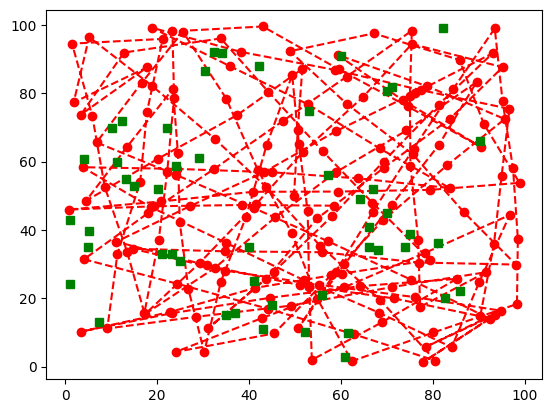

In [6]:
#------------
# User Instructions
#
# In this problem you will implement a more manageable
# version of graph SLAM in 2 dimensions.
#
# Define a function, online_slam, that takes 5 inputs:
# data, N, num_landmarks, motion_noise, and
# measurement_noise--just as was done in the last
# programming assignment of unit 6. This function
# must return TWO matrices, mu and the final Omega.
#
# Just as with the quiz, your matrices should have x
# and y interlaced, so if there were two poses and 2
# landmarks, mu would look like:
#
# mu = matrix([[Px0],
#              [Py0],
#              [Px1],
#              [Py1],
#              [Lx0],
#              [Ly0],
#              [Lx1],
#              [Ly1]])
#
# Enter your code at line 566.

# -----------
# Testing
#
# You have two methods for testing your code.
#
# 1) You can make your own data with the make_data
#    function. Then you can run it through the
#    provided slam routine and check to see that your
#    online_slam function gives the same estimated
#    final robot pose and landmark positions.
# 2) You can use the solution_check function at the
#    bottom of this document to check your code
#    for the two provided test cases. The grading
#    will be almost identical to this function, so
#    if you pass both test cases, you should be
#    marked correct on the homework.

from math import *
import random
import matplotlib.pyplot as plt



# ------------------------------------------------
#
# this is the matrix class
# we use it because it makes it easier to collect constraints in GraphSLAM
# and to calculate solutions (albeit inefficiently)
#

class matrix:

    # implements basic operations of a matrix class

    # ------------
    #
    # initialization - can be called with an initial matrix
    #

    def __init__(self, value = [[]]):
        self.value = value
        self.dimx  = len(value)
        self.dimy  = len(value[0])
        if value == [[]]:
            self.dimx = 0

    # -----------
    #
    # defines matrix equality - returns true if corresponding elements
    #   in two matrices are within epsilon of each other.
    #

    def __eq__(self, other):
        epsilon = 0.01
        if self.dimx != other.dimx or self.dimy != other.dimy:
            return False
        for i in range(self.dimx):
            for j in range(self.dimy):
                if abs(self.value[i][j] - other.value[i][j]) > epsilon:
                    return False
        return True

    def __ne__(self, other):
        return not (self == other)

    # ------------
    #
    # makes matrix of a certain size and sets each element to zero
    #

    def zero(self, dimx, dimy):
        if dimy == 0:
            dimy = dimx
        # check if valid dimensions
        if dimx < 1 or dimy < 1:
            raise ValueError ("Invalid size of matrix")
        else:
            self.dimx  = dimx
            self.dimy  = dimy
            self.value = [[0.0 for row in range(dimy)] for col in range(dimx)]

    # ------------
    #
    # makes matrix of a certain (square) size and turns matrix into identity matrix
    #

    def identity(self, dim):
        # check if valid dimension
        if dim < 1:
            raise ValueError("Invalid size of matrix")
        else:
            self.dimx  = dim
            self.dimy  = dim
            self.value = [[0.0 for row in range(dim)] for col in range(dim)]
            for i in range(dim):
                self.value[i][i] = 1.0

    # ------------
    #
    # prints out values of matrix
    #

    def show(self, txt = ''):
        for i in range(len(self.value)):
            print (txt + '['+ ', '.join('%.3f'%x for x in self.value[i]) + ']')
        print (' ')

    # ------------
    #
    # defines elmement-wise matrix addition. Both matrices must be of equal dimensions
    #

    def __add__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimension to add")
        else:
            # add if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] + other.value[i][j]
            return res

    # ------------
    #
    # defines elmement-wise matrix subtraction. Both matrices must be of equal dimensions
    #

    def __sub__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimension to subtract")
        else:
            # subtract if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] - other.value[i][j]
            return res

    # ------------
    #
    # defines multiplication. Both matrices must be of fitting dimensions
    #

    def __mul__(self, other):
        # check if correct dimensions
        if self.dimy != other.dimx:
            raise ValueError("Matrices must be m*n and n*p to multiply")
        else:
            # multiply if correct dimensions
            res = matrix()
            res.zero(self.dimx, other.dimy)
            for i in range(self.dimx):
                for j in range(other.dimy):
                    for k in range(self.dimy):
                        res.value[i][j] += self.value[i][k] * other.value[k][j]
        return res

    # ------------
    #
    # returns a matrix transpose
    #

    def transpose(self):
        # compute transpose
        res = matrix()
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[ 1,  2,  3,  4,  5],
    #                   [ 6,  7,  8,  9, 10],
    #                   [11, 12, 13, 14, 15]])
    #
    #       l.take([0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 3, 4],
    #        [11, 13, 14]]
    #
    #
    # take is used to remove rows and columns from existing matrices
    # list1/list2 define a sequence of rows/columns that shall be taken
    # is no list2 is provided, then list2 is set to list1 (good for symmetric matrices)
    #

    def take(self, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError("list invalid in take()")

        res = matrix()
        res.zero(len(list1), len(list2))
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[i][j] = self.value[list1[i]][list2[j]]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[1, 2, 3],
    #                  [4, 5, 6]])
    #
    #       l.expand(3, 5, [0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 0, 2, 3, 0],
    #        [0, 0, 0, 0, 0],
    #        [4, 0, 5, 6, 0]]
    #
    # expand is used to introduce new rows and columns into an existing matrix
    # list1/list2 are the new indexes of row/columns in which the matrix
    # elements are being mapped. Elements for rows and columns
    # that are not listed in list1/list2
    # will be initialized by 0.0.
    #

    def expand(self, dimx, dimy, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError("list invalid in expand()")

        res = matrix()
        res.zero(dimx, dimy)
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[list1[i]][list2[j]] = self.value[i][j]
        return res

    # ------------
    #
    # Computes the upper triangular Cholesky factorization of
    # a positive definite matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def Cholesky(self, ztol= 1.0e-5):

        res = matrix()
        res.zero(self.dimx, self.dimx)

        for i in range(self.dimx):
            S = sum([(res.value[k][i])**2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else:
                if d < 0.0:
                    raise ValueError("Matrix not positive-definite")
                res.value[i][i] = sqrt(d)
            for j in range(i+1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(i)])
                if abs(S) < ztol:
                    S = 0.0
                try:
                   res.value[i][j] = (self.value[i][j] - S)/res.value[i][i]
                except:
                   raise ValueError("Zero diagonal")
        return res

    # ------------
    #
    # Computes inverse of matrix given its Cholesky upper Triangular
    # decomposition of matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def CholeskyInverse(self):
    # Computes inverse of matrix given its Cholesky upper Triangular
    # decomposition of matrix.
        # This code is based on http://adorio-research.org/wordpress/?p=4560

        res = matrix()
        res.zero(self.dimx, self.dimx)

    # Backward step for inverse.
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k]*res.value[j][k] for k in range(j+1, self.dimx)])
            res.value[j][j] = 1.0/ tjj**2 - S/ tjj
            for i in reversed(range(j)):
                res.value[j][i] = res.value[i][j] = \
                    -sum([self.value[i][k]*res.value[k][j] for k in \
                              range(i+1,self.dimx)])/self.value[i][i]
        return res

    # ------------
    #
    # comutes and returns the inverse of a square matrix
    #

    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res

    # ------------
    #
    # prints matrix (needs work!)
    #

    def __repr__(self):
        return repr(self.value)

# ######################################################################

# ------------------------------------------------
#
# this is the robot class
#
# our robot lives in x-y space, and its motion is
# pointed in a random direction. It moves on a straight line
# until is comes close to a wall at which point it turns
# away from the wall and continues to move.
#
# For measurements, it simply senses the x- and y-distance
# to landmarks. This is different from range and bearing as
# commonly studies in the literature, but this makes it much
# easier to implement the essentials of SLAM without
# cluttered math
#

class robot:

    # --------
    # init:
    #   creates robot and initializes location to 0, 0
    #

    def __init__(self, world_size = 100.0, measurement_range = 30.0,
                 motion_noise = 1.0, measurement_noise = 1.0):
        self.measurement_noise = 0.0
        self.world_size = world_size
        self.measurement_range = measurement_range
        self.x = world_size / 2.0
        self.y = world_size / 2.0
        self.motion_noise = motion_noise
        self.measurement_noise = measurement_noise
        self.landmarks = []
        self.num_landmarks = 0


    def rand(self):
        return random.random() * 2.0 - 1.0

    # --------
    #
    # make random landmarks located in the world
    #

    def make_landmarks(self, num_landmarks):
        self.landmarks = []
        for i in range(num_landmarks):
            self.landmarks.append([round(random.random() * self.world_size),
                                   round(random.random() * self.world_size)])
        self.num_landmarks = num_landmarks

    # --------
    #
    # move: attempts to move robot by dx, dy. If outside world
    #       boundary, then the move does nothing and instead returns failure
    #

    def move(self, dx, dy):

        x = self.x + dx + self.rand() * self.motion_noise
        y = self.y + dy + self.rand() * self.motion_noise

        if x < 0.0 or x > self.world_size or y < 0.0 or y > self.world_size:
            return False
        else:
            self.x = x
            self.y = y
            return True

    # --------
    #
    # sense: returns x- and y- distances to landmarks within visibility range
    #        because not all landmarks may be in this range, the list of measurements
    #        is of variable length. Set measurement_range to -1 if you want all
    #        landmarks to be visible at all times
    #

    def sense(self):
        Z = []
        for i in range(self.num_landmarks):
            dx = self.landmarks[i][0] - self.x + self.rand() * self.measurement_noise
            dy = self.landmarks[i][1] - self.y + self.rand() * self.measurement_noise
            if self.measurement_range < 0.0 or abs(dx) + abs(dy) <= self.measurement_range:
                Z.append([i, dx, dy])
        return Z

    # --------
    #
    # print robot location
    #

    def __repr__(self):
        return 'Robot: [x=%.5f y=%.5f]'  % (self.x, self.y)


# ######################################################################

# --------
# this routine makes the robot data
#

def make_data(N, num_landmarks, world_size, measurement_range, motion_noise,
              measurement_noise, distance):

    complete = False

    while not complete:

        data = []

        # make robot and landmarks
        r = robot(world_size, measurement_range, motion_noise, measurement_noise)
        r.make_landmarks(num_landmarks)
        seen = [False for row in range(num_landmarks)]

        # guess an initial motion
        orientation = random.random() * 2.0 * pi
        dx = cos(orientation) * distance
        dy = sin(orientation) * distance

        for k in range(N-1):

            # sense
            Z = r.sense()

            # check off all landmarks that were observed
            for i in range(len(Z)):
                seen[Z[i][0]] = True

            # move
            while not r.move(dx, dy):
                # if we'd be leaving the robot world, pick instead a new direction
                orientation = random.random() * 2.0 * pi
                dx = cos(orientation) * distance
                dy = sin(orientation) * distance

            # memorize data
            data.append([Z, [dx, dy]])

        # we are done when all landmarks were observed; otherwise re-run
        complete = (sum(seen) == num_landmarks)

    print (' ')
    print ('Landmarks: ', r.landmarks)
    print (r)

    return data

# ######################################################################

# --------------------------------
#
# full_slam - retains entire path and all landmarks
#             Feel free to use this for comparison.
#

def slam(data, N, num_landmarks, motion_noise, measurement_noise):

    # Set the dimension of the filter
    dim = 2 * (N + num_landmarks)

    # make the constraint information matrix and vector
    Omega = matrix()
    Omega.zero(dim, dim)
    Omega.value[0][0] = 1.0
    Omega.value[1][1] = 1.0

    Xi = matrix()
    Xi.zero(dim, 1)
    Xi.value[0][0] = world_size / 2.0
    Xi.value[1][0] = world_size / 2.0

    # process the data

    for k in range(len(data)):

        # n is the index of the robot pose in the matrix/vector
        n = k * 2

        measurement = data[k][0]
        motion      = data[k][1]

        # integrate the measurements
        for i in range(len(measurement)):

            # m is the index of the landmark coordinate in the matrix/vector
            m = 2 * (N + measurement[i][0])

            # update the information maxtrix/vector based on the measurement
            for b in range(2):
                Omega.value[n+b][n+b] +=  1.0 / measurement_noise
                Omega.value[m+b][m+b] +=  1.0 / measurement_noise
                Omega.value[n+b][m+b] += -1.0 / measurement_noise
                Omega.value[m+b][n+b] += -1.0 / measurement_noise
                Xi.value[n+b][0]      += -measurement[i][1+b] / measurement_noise
                Xi.value[m+b][0]      +=  measurement[i][1+b] / measurement_noise


        # update the information maxtrix/vector based on the robot motion
        for b in range(4):
            Omega.value[n+b][n+b] +=  1.0 / motion_noise
        for b in range(2):
            Omega.value[n+b  ][n+b+2] += -1.0 / motion_noise
            Omega.value[n+b+2][n+b  ] += -1.0 / motion_noise
            Xi.value[n+b  ][0]        += -motion[b] / motion_noise
            Xi.value[n+b+2][0]        +=  motion[b] / motion_noise

    # compute best estimate
    mu = Omega.inverse() * Xi

    # return the result
    return mu

# --------------------------------
#
# online_slam - retains all landmarks but only most recent robot pose
#

def online_slam(data, N, num_landmarks, motion_noise, measurement_noise):
    #
    #
    # Enter your code here!

    #set the dimension of the filter
    dim = 2*(1 + num_landmarks)

    #make the constraint information matrix and vector
    Omega = matrix()
    Omega.zero(dim,dim)
    Omega.value[0][0] = 1.0
    Omega.value[1][1] = 1.0

    Xi = matrix()
    Xi.zero(dim,1)
    #posicion inicial al medio
    Xi.value[0][0]=world_size / 2.
    Xi.value[1][0]=world_size / 2.

    #process the data

    for k in range(len(data)):

        measurement = data[k][0]
        motion      = data[k][1]

        #integrate the measurements
        for i in range(len(measurement)):

            #m is the index of the landmark coordinate in the matrix/vector
            m = 2*(1 + measurement[i][0])

            #update the information matrix/vector based on the measurement

            for b in range(2):
                Omega.value[b][b]     +=  1.0 / measurement_noise
                Omega.value[m+b][m+b] +=  1.0 / measurement_noise
                Omega.value[b][m+b]   += -1.0 / measurement_noise
                Omega.value[m+b][b]   += -1.0 / measurement_noise
                Xi.value[b][0]        += -measurement[i][1+b] / measurement_noise
                Xi.value[m+b][0]      +=  measurement[i][1+b] / measurement_noise

        #expand the information matrix and vector by one new position

        list1=[0,1] + list(range(4,dim+2))
        Omega = Omega.expand(dim+2,dim+2,list1,list1)
        Xi = Xi.expand(dim+2, 1,list1, [0])


        #update the information matrix/vector based on the robot motion
        for b in range(4):
            Omega.value[b][b]     += 1. / motion_noise
        for b in range(2):
            Omega.value[b  ][b+2] += -1. / motion_noise
            Omega.value[b+2][b  ] += -1. / motion_noise
            Xi.value[b  ][0]      += -motion[b] / motion_noise
            Xi.value[b+2][0]      +=  motion[b] / motion_noise

        # now factor out the previous pose
        newlist = range(2,len(Omega.value))
        a = Omega.take([0,1],newlist)
        b = Omega.take([0,1])
        c = Xi.take([0,1],[0])
        Omega = Omega.take(newlist) - a.transpose() * b.inverse() * a
        Xi = Xi.take(newlist, [0]) - a.transpose() * b.inverse() * c

    mu = Omega.inverse() * Xi

    #
    #
    return mu, Omega # make sure you return both of these matrices to be marked correct.

# --------------------------------
#
# print the result of SLAM, the robot pose(s) and the landmarks
#

def print_result(N, num_landmarks, result):
    print ()
    print ('Estimated Pose(s):')
    for i in range(N):
        print ('    ['+ ', '.join('%.3f'%x for x in result.value[2*i]) + ', ' \
            + ', '.join('%.3f'%x for x in result.value[2*i+1]) +']')
    print ()
    print ('Estimated Landmarks:')
    for i in range(num_landmarks):
        print ('    ['+ ', '.join('%.3f'%x for x in result.value[2*(N+i)]) + ', ' \
            + ', '.join('%.3f'%x for x in result.value[2*(N+i)+1]) +']')

def graph_result(N, num_landmarks, result):
    x_trajectory = []
    y_trajectory = []
    x_landmark = []
    y_landmark = []

    #rint(result)
    #print(result.value)
    #print(result.value[0][0])

    for i in range(N):
        x_trajectory.append(result.value[2*i][0])
        y_trajectory.append(result.value[2*i+1][0])
    for i in range(num_landmarks):
        x_landmark.append(result.value[2*(N+i)][0])
        y_landmark.append(result.value[2*(N+i)+1][0])

    plt.plot(x_trajectory, y_trajectory, 'r--', x_trajectory, y_trajectory, 'ro', x_landmark, y_landmark, 'gs')
    plt.show()

# ------------------------------------------------------------------------
#
# Main routines
#

num_landmarks      = 50       # number of landmarks
N                  = 200       # time steps
world_size         = 100.0    # size of world
measurement_range  = 50.0     # range at which we can sense landmarks
motion_noise       = 2.0      # noise in robot motion
measurement_noise  = 2.0      # noise in the measurements
distance           = 20.0     # distance by which robot (intends to) move each iteratation


# Uncomment the following three lines to run the full slam routine.

data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)
#result = slam(data, N, num_landmarks, motion_noise, measurement_noise)
print_result(N, num_landmarks, result)
graph_result(N,num_landmarks,result)

# Uncomment the following three lines to run the online_slam routine.

#data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)
#result = online_slam(data, N, num_landmarks, motion_noise, measurement_noise)
#print_result(1, num_landmarks, result[0])
#graph_result(1,num_landmarks,result[0])

##########################################################

# ------------
# TESTING
#
# Uncomment one of the test cases below to check that your
# online_slam function works as expected.

# -----------
# Test Case 1

testdata1          = [[[[1, 21.796713239511305, 25.32184135169971], [2, 15.067410969755826, -27.599928007267906]], [16.4522379034509, -11.372065246394495]],
                      [[[1, 6.1286996178786755, 35.70844618389858], [2, -0.7470113490937167, -17.709326161950294]], [16.4522379034509, -11.372065246394495]],
                      [[[0, 16.305692184072235, -11.72765549112342], [2, -17.49244296888888, -5.371360408288514]], [16.4522379034509, -11.372065246394495]],
                      [[[0, -0.6443452578030207, -2.542378369361001], [2, -32.17857547483552, 6.778675958806988]], [-16.66697847355152, 11.054945886894709]]]

answer_mu1         = matrix([[81.63549976607898],
                             [27.175270706192254],
                             [98.09737507003692],
                             [14.556272940621195],
                             [71.97926631050574],
                             [75.07644206765099],
                             [65.30397603859097],
                             [22.150809430682695]])

answer_omega1      = matrix([[0.36603773584905663, 0.0, -0.169811320754717, 0.0, -0.011320754716981133, 0.0, -0.1811320754716981, 0.0],
                             [0.0, 0.36603773584905663, 0.0, -0.169811320754717, 0.0, -0.011320754716981133, 0.0, -0.1811320754716981],
                             [-0.169811320754717, 0.0, 0.6509433962264151, 0.0, -0.05660377358490567, 0.0, -0.40566037735849064, 0.0],
                             [0.0, -0.169811320754717, 0.0, 0.6509433962264151, 0.0, -0.05660377358490567, 0.0, -0.40566037735849064],
                             [-0.011320754716981133, 0.0, -0.05660377358490567, 0.0, 0.6962264150943396, 0.0, -0.360377358490566, 0.0],
                             [0.0, -0.011320754716981133, 0.0, -0.05660377358490567, 0.0, 0.6962264150943396, 0.0, -0.360377358490566],
                             [-0.1811320754716981, 0.0, -0.4056603773584906, 0.0, -0.360377358490566, 0.0, 1.2339622641509433, 0.0],
                             [0.0, -0.1811320754716981, 0.0, -0.4056603773584906, 0.0, -0.360377358490566, 0.0, 1.2339622641509433]])

#result = online_slam(testdata1, 5, 3, 2.0, 2.0)


# -----------
# Test Case 2

testdata2          = [[[[0, 12.637647070797396, 17.45189715769647], [1, 10.432982633935133, -25.49437383412288]], [17.232472057089492, 10.150955955063045]],
                      [[[0, -4.104607680013634, 11.41471295488775], [1, -2.6421937245699176, -30.500310738397154]], [17.232472057089492, 10.150955955063045]],
                      [[[0, -27.157759429499166, -1.9907376178358271], [1, -23.19841267128686, -43.2248146183254]], [-17.10510363812527, 10.364141523975523]],
                      [[[0, -2.7880265859173763, -16.41914969572965], [1, -3.6771540967943794, -54.29943770172535]], [-17.10510363812527, 10.364141523975523]],
                      [[[0, 10.844236516370763, -27.19190207903398], [1, 14.728670653019343, -63.53743222490458]], [14.192077112147086, -14.09201714598981]]]

answer_mu2         = matrix([[63.37479912250136],
                             [78.17644539069596],
                             [61.33207502170053],
                             [67.10699675357239],
                             [62.57455560221361],
                             [27.042758786080363]])

answer_omega2      = matrix([[0.22871751620895048, 0.0, -0.11351536555795691, 0.0, -0.11351536555795691, 0.0],
                             [0.0, 0.22871751620895048, 0.0, -0.11351536555795691, 0.0, -0.11351536555795691],
                             [-0.11351536555795691, 0.0, 0.7867205207948973, 0.0, -0.46327947920510265, 0.0],
                             [0.0, -0.11351536555795691, 0.0, 0.7867205207948973, 0.0, -0.46327947920510265],
                             [-0.11351536555795691, 0.0, -0.46327947920510265, 0.0, 0.7867205207948973, 0.0],
                             [0.0, -0.11351536555795691, 0.0, -0.46327947920510265, 0.0, 0.7867205207948973]])

#result = online_slam(testdata2, 6, 2, 3.0, 4.0)
#print_result(1, num_landmarks, result[0])
#graph_result(1,num_landmarks,result[0])